<a href="https://colab.research.google.com/github/NataliaBlueCloud/traffic-latency-simulator/blob/main/simulation_MG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
system('git clone https://github.com/NataliaBlueCloud/traffic-latency-simulator.git')


In [2]:
install.packages("igraph")
install.packages("simmer")
install.packages("SciViews")
install.packages("hrbrthemes")
install.packages("viridis")
install.packages("googledrive")
install.packages("readxl")
install.packages("openxlsx")
install.packages("doParallel")
install.packages("foreach")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fontBitstreamVera’, ‘fontLiberation’, ‘extrafontdb’, ‘Rttf2pt1’, ‘fontquiver’, ‘extrafont’, ‘gdtools’


Warning message in install.packages("hrbrthemes"):
“installation of package ‘gdtools’ had non-zero exit status”
Warning message in install.packages("hrbrthemes"):
“installation of package ‘hrbrthemes’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-li

In [3]:
library(ggplot2)
library(igraph)
library(stringr)
library(tidyverse)
library(readr)
library(SciViews)
library(dplyr)
library(viridis)
library(readxl)
library(openxlsx)
library(simmer)
library(doParallel)
library(foreach)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite


Attaching

In [4]:
source("/content/traffic-latency-simulator/func/igraph_functions.R")
source("/content/traffic-latency-simulator/func/general_function_base.R")
source("/content/traffic-latency-simulator/func/simmer_function_base.R")

#Input data

The **average packet size** is taken from: Amsterdam Internet Exchange Ethernet Frame Size Distribution, statistics available online at https://stats.ams-ix.net/sflow/size.html, accessed on July 2023

Packet sizes in Bytes: 64-127, 128-511, 512 - 1023, 1024 - 1513, 1514, more than 1515.


With their probabilities: 0.332, 0.054, 0.033, 0.037, 0.346, 0.146, 0.052

In [5]:
PS_size=c((64+127)/2,(128+255)/2,(256+511)/2, (512+1023)/2, (1024+1513)/2, 1514, (1515+9100)/2)
PS_weights=c(33.2/100, 5.4/100, 3.3/100, 3.7/100, 34.6/100, 14.6/100, 5.2/100)
N = sum(PS_size*PS_weights)
N
var_N <- sum(PS_size^2*PS_weights) - N^2
Cs2 <- var_N/(N^2)

CapacityGbps = 10
#Calculation of delays for different capacities
Load_local = 0.3
Load_regional = 0.5
Load_national = 0.4

[1] 1019.035

Input excel file with topology information: links, nodes, traffic

Prefix base - the common name for the nodes in the file.

In [6]:
topology_choice <- readline(prompt = "Enter 'Tokyo', 'Milano', or 'MAN157' to choose the respective topology: ")

# Define the file paths based on user input
if (tolower(topology_choice) == "tokyo" | tolower(topology_choice) == "Tokyo") {
  file_name_v2 <- "/content/traffic-latency-simulator/input_files/Metro_topology_full_Tokyo.xlsx"
  prefix_base <- "Tokyo_"
  topology_name = "Tokyo"
  print(file_name_v2)
} else if (tolower(topology_choice) == "milano" | tolower(topology_choice) == "Milano") {
  file_name_v2 <- "/content/traffic-latency-simulator/input_files/Metro_topology_full_Milano.xlsx"
  prefix_base <- "Node"
  topology_name = "Milano"
  print(file_name_v2)
} else if (tolower(topology_choice) == "man157" | tolower(topology_choice) == "MAN157") {
  file_name_v2 <- "/content/traffic-latency-simulator/input_files/Metro_topology_MAN157.xlsx"
  prefix_base <- "Node"
  topology_name = "MAN157"
  print(file_name_v2)
} else {
  stop("Invalid input. Please enter either 'Tokyo', 'Milano', or 'MAN157'.")
}

Enter 'Tokyo', 'Milano', or 'MAN157' to choose the respective topology: Milano
[1] "/content/traffic-latency-simulator/input_files/Metro_topology_full_Milano.xlsx"


In [7]:
nodes_info <- read_excel(file_name_v2, sheet = 1)
links_info <- read_excel(file_name_v2, sheet = 2)
traffic_file <- read_excel(file_name_v2, sheet = 3)

In [8]:
print(links_info)
print(nodes_info)
print(traffic_file)

# A tibble: 202 × 4
   sourceID destinationID distanceKm capacityGbps
   <chr>    <chr>              <dbl>        <dbl>
 1 Node1    Node2                1             0 
 2 Node1    Node3                1             0 
 3 Node1    Node4                1             0 
 4 Node1    Node8                1          3824.
 5 Node2    Node1                1             0 
 6 Node2    Node5                1          3998.
 7 Node2    Node6                1             0 
 8 Node2    Node7                1             0 
 9 Node3    Node1                1             0 
10 Node3    Node4                0.8           0 
# ℹ 192 more rows
# A tibble: 52 × 11
   node_name node_code `Node Type`  `Central office type` Reference Regional C…¹
   <chr>     <chr>     <chr>        <chr>                 <chr>                 
 1 Node1     HL2       Metro Core   Regional CO           Node1                 
 2 Node2     HL2       Metro Core   Regional CO           Node2                 
 3 Node3     HL2  

Definition of national and regional Cental Offices (COs).

In [9]:
national_nodes <- c()
regional_nodes <- c()

for (i in seq_along(nodes_info$node_code)) {
  if (nodes_info$node_code[i] == "HL2") {
    national_nodes <- c(national_nodes, i)
  }
  if (nodes_info$node_code[i] == "HL3") {
    regional_nodes <- c(regional_nodes, i)
  }
}

cat("National nodes:", national_nodes, "\n")
cat("Regional nodes:", regional_nodes, "\n")

National nodes: 1 2 3 4 5 6 7 8 21 22 23 24 
Regional nodes: 9 10 11 12 13 14 15 16 17 18 19 20 40 41 42 43 44 


#Functions

### Vysochanskij–Petunin's bound calculation function
Inputs:
- **delay_hops**: Vector of delay at each hop
- **a**: Upper bound percentile from 0 to 1

Output:
- Vysochanskij–Petunin's upper bound


In [10]:
func_bounds_VP <- function(delay_hops, a)
{
  mu = sum(delay_hops)
  sigma = sqrt(sum(delay_hops^2))
  k <- sqrt(4/9/(1-a))
  Prop_VP <- 1 - 4/9/(k^2)
  upper_bound_VP <- k * sigma + mu
  return(upper_bound_VP)
}

##Simmer simulation


### Function to perform simulation in a simmer environment with M/G/1 queueing model
Inputs:
- **env**: Simmer environment
- **from**: Source node
- **to**: Destination node
- **graph**: Graph object representing the network topology
- **traffic_val**: Traffic value (lambda) for the simulation
- **log_info**: Information for logging purposes
- **PS_size**: Packet size
- **PS_weights**: Packet weights

Output:
- List containing updated environment, trajectory name, transmission delay, and propagation delay


In [11]:
simmer_simulation_mg1 <- function(env, from, to, graph, traffic_val, log_info, PS_size, PS_weights)
{
  name = paste0('traffic_', from, "_", to, "_", log_info)
  if (from != to && traffic_val != 0) {
    c(traffic, delay_transm, delay_prop) := simmer_trajectory_simulation_mg1(env, from, to, trajectory_name = traffic , graph, log_info, PS_size = PS_size, PS_weights = PS_weights) #creating trajectory
    assign(name, traffic)
    print(name)
    #print(get(name))
    env<- simmer_generator(env, get(name), name, traffic_val)
  }
  return(list(env, name, delay_transm, delay_prop))
}

### Function to create cross trajectories in the simmer environment based on the network load
Inputs:
- **env**: Simmer environment
- **g**: Graph object representing the network topology
- **from**: Source node
- **to**: Destination node
- **lambda_simmer**: Traffic value (lambda) for the simulation
- **PS_size**: Packet size
- **PS_weights**: Packet weights

Output:
- Updated simmer environment

In [12]:
simmer_crosstrajectory_simulation_mg1 <- function(env, g, from, to, lambda_simmer, PS_size, PS_weights)
{
  path <- shortest_paths(g, from, to, weights = NULL, output = "both", algorithm = c("automatic"))
  N = sum(PS_size*PS_weights)
  path_size <- length(path[["vpath"]][[1]])
  nodes_capacity <- rep(0, length(V(g)))
  nodes_capacity[path[["vpath"]][[1]][-path_size]] <- E(g)$capacityGbps[path[["epath"]][[1]]]
  nodes_capacity_Bps <- nodes_capacity*1e9
  nodes_capacity <- nodes_capacity_Bps/(8*N)

  nodes_load <- rep(0, length(V(g)))
  nodes_load[path[["vpath"]][[1]][-path_size]] <- E(g)$Load[path[["epath"]][[1]]]

  for (i in path[["vpath"]][[1]][-path_size])
  {

    load_compare <- lambda_simmer/(nodes_capacity[i])
    if (nodes_load[i] > load_compare )
    {
      print(paste0("node_", i))
      print(nodes_capacity[i])
      print(nodes_load[i])
      trajectory_name <- trajectory() %>%
        seize(paste0("node_", i)) %>%
        set_attribute("capacity", nodes_capacity_Bps[i]) %>%
        timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(get_attribute(env, "capacity"))) %>%
        release(paste0("node_", i)) #%>%

      name <- paste0("traffic_cross_", from,"_", to, "_node_", i,"_")
      assign(name, trajectory_name)
      traffic_val <- nodes_load[i] * nodes_capacity[i] - lambda_simmer
      print(traffic_val)
      print(lambda_simmer)
      print(nodes_load[i]*nodes_capacity[i])
      env<- simmer_generator(env, get(name), name, traffic_val)
    }
  }
  return(env)
}



### Main function to perform simulation using trajectories in a simmer environment
Inputs:
- **g**: Graph object representing the network topology
- **traffic_file**: Data frame containing traffic information
- **PS_size**: Packet size
- **PS_weights**: Packet weights
- **load**: Traffic load (default: $0.3$)
- **CapacityGbps**: Link capacity in Gbps (default: $10~Gb/s$)

Output:
- List containing delay and traffic information

In [ ]:

simulation_simmer <- function(g, traffic_file, PS_size, PS_weights, load = 0.3,
                              CapacityGbps = 10, ncores=1){
  E(g)$Queue_Delay_sim <- 0
  E(g)$Queue_Delay_theor_VP_upbound99 <- 0
  E(g)$Queue_Delay_sim_99p <- 0

  #####################################simmer
  queue_delay_tr_flow <- numeric(nrow(traffic_file))
  # queue_delay_tr_flow <- numeric(nrow(traffic_file))
  prop_delay_tr_flow <- numeric(nrow(traffic_file))
  delay_tr_flow <- numeric(nrow(traffic_file))
  delay_tr_flow_p_99 <- numeric(nrow(traffic_file))
  exp_delay_igraph <- numeric(nrow(traffic_file))
  delay_tr_flow_VP_upbound_p_99_100 <- numeric(nrow(traffic_file))
  digits = 10
  print("start simulation in simmer")
  N = sum(PS_size*PS_weights)
  cat("Load = ",load, "\n")
  traffic_file$traffic_ps <- CapacityGbps*1e9/(8*N)*load
  traffic_file$trafficGbps <- CapacityGbps*load
  assign("traffic_file", traffic_file, .GlobalEnv)
  cluster <- makeCluster(ncores)
  print(cluster)
  registerDoParallel(cluster)
  results = numeric(nrow(traffic_file))
  results <- foreach (line = 1:nrow(traffic_file)) %dopar%
  #forend <- foreach (line = 1:4) %dopar%
  {
    print(line)
    if(traffic_file$sourceID[line] != traffic_file$destinationID[line] && traffic_file$traffic_ps[line] != 0)
    {
      file_param = paste0(line,"_params")
      file_result = paste0(line, "_results")
      save(line, traffic_file, g, PS_size, PS_weights, file=file_param)
      command <- paste0("Rscript /content/traffic-latency-simulator/parallelized_v2/traffic_flow_simulation.R ", file_param)
      out_res<-system(command)
      print(out_res)
      load(file_result)
      unlink(file_param)
      unlink(file_result)
      results[line]<-res
    } else{
      print("no info of traffic")
      results[line]<-(c(0,0,NaN,0,0,0))
    }
  }
  stopCluster(cluster)
  print(results)
  i=0
  for (res in results){
    i=i+1
    exp_delay_igraph[i]<- res[1]
    queue_delay_tr_flow[i] <- res[2]
    prop_delay_tr_flow[i] <- res[3]
    delay_tr_flow[i] <- res[4]
    delay_tr_flow_p_99[i] <- res[5]
    delay_tr_flow_VP_upbound_p_99_100[i] <-res[6]
  }

  igraph_df_calc <- data_frame(exp_delay_igraph, delay_tr_flow, delay_tr_flow_p_99, delay_tr_flow_VP_upbound_p_99_100)

  assign("igraph_df_calc", igraph_df_calc, .GlobalEnv)

  return(list(delay_tr_flow, exp_delay_igraph, delay_tr_flow_p_99, delay_tr_flow_VP_upbound_p_99_100, g))
}

### Function to calculate end-to-end delays theoretically
Inputs:
- **g**: Graph object representing the network topology
- **traffic_file**: Data frame containing traffic information
- **Cs2**: coefficient of variation of service time

Output:
- List containing updated graph and theoretical delay values

In [14]:
prop_queue_tr_delay_e2e <- function(g, traffic_file, Cs2){

  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Load/(1-E(g)$Load)/E(g)$Traffic*(Cs2 + 1)/2) #M/G/1
  latencyPropTransQueuing_theor_s <- rep(0, nrow(traffic_file))
  latencyPercentile99_theor_s <- rep(0, nrow(traffic_file))
  for (line in 1:nrow(traffic_file))
  {
    if(traffic_file$traffic_ps[line] != 0){
      vertex_sourse <- which(V(g)$name==traffic_file$sourceID[line])
      vertex_destination<- which(V(g)$name==traffic_file$destinationID[line])
      path <- shortest_paths(g, vertex_sourse, vertex_destination,
                             weights = NULL,
                             output = "both",
                             algorithm = c("automatic"))
      latencyPropTransQueuing_theor_s[line] = sum(E(g)[path[["epath"]][[1]]]$Queue_Delay) + sum(E(g)[path[["epath"]][[1]]]$Prop_Delay)
      latencyPercentile99_theor_s[line] <- func_bounds_VP(E(g)[path[["epath"]][[1]]]$Queue_Delay, 0.99) + sum(E(g)[path[["epath"]][[1]]]$Prop_Delay)
    }
    else {
      latencyPropTransQueuing_theor_s[line] <- 0
      latencyPercentile99_theor_s[line] <- 0
    }
  }
  return(list(g, latencyPropTransQueuing_theor_s, latencyPercentile99_theor_s))
}


##Igraph calculations


### Main function to perform simulation using theoretical delay calculations
Inputs:
- **nodes_info**: Information about nodes in the network
- **links_info**: Information about links in the network
- **traffic_file**: Data frame containing traffic information
- **Capacity**: Link capacity in Gbps (default: $10~Gb/s$)
- **calc_dist**: Flag to calculate distance (default: $FALSE$)
- **distance**: Custom distance parameter (default: $5$)
- **Load_local**: Local traffic load (default: $0.3$)
- **Load_regional**: Regional traffic load (default: $0.5$)
- **Load_national**: National traffic load (default: $0.4$)
- **prefix_base**: Base prefix for nodes
- **national_nodes**: List of national nodes
- **regional_nodes**: List of regional nodes
- **N**: Number of packets
- **Cs2**: coefficient of variation of service time

Output:
- List containing updated graph and delay information

In [15]:
simulation_igraph <- function(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist =  FALSE, distance = 5, Load_local = 0.3, Load_regional = 0.5, Load_national = 0.4, prefix_base, national_nodes, regional_nodes, N, Cs2){

  traffic_file$traffic_ps <- traffic_file$trafficGbps*10^9/(8*N)
  g = graph_from_data_frame(links_info, directed = TRUE)
  E(g)$capacityGbps <- Capacity
  for (NCO in national_nodes){
    a <- (filter(traffic_file, traffic_file$destinationID == V(g)$name[NCO]))
    size <- length(a$destinationID)
    E(g)$capacityGbps[incident(g, NCO, mode = c("in"))] <- Capacity*size
  }
  E(g)$Capacity <- E(g)$capacityGbps*1e9/(8*N) #p/s
  ############distance put original distance(calc_dist = 1) or custom distance (calc_dist = 1) with paramentr "distance" in km
  if( calc_dist == TRUE ) {
    E(g)$Distance = E(g)$distanceKm * distance
  }
  else {
    E(g)$Distance <- E(g)$distanceKm
  }
  ####Load of the links
  #for Local CO
  E(g)$Load <- Load_local
  #national COs
  for (NCO in national_nodes){
    E(g)$Load[incident(g, NCO, mode = c("in"))] <- Load_national
  }
  #regional COs
  for (RCO in regional_nodes){
    E(g)$Load[incident(g, RCO, mode = c("in"))] <- Load_regional
  }

  E(g)$Traffic <- E(g)$Capacity * E(g)$Load
  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance
  c(g, traffic_file$latencyPropTransQueuing_theor_s_mg1, traffic_file$latencyPercentile99_theor_s_mg1) := prop_queue_tr_delay_e2e(g, traffic_file, Cs2)

  data_av <- traffic_file$latencyPropTransQueuing_theor_s_mg1
  data_99 <- traffic_file$latencyPercentile99_theor_s_mg1


  assign("traffic_file", traffic_file, .GlobalEnv)

  links_info$prop_delay_s <- 5*10^(-6)*links_info$distanceKm
  assign("links_info_df", links_info, .GlobalEnv)

  #removing the local traffic
  data_av <- data_av[data_av != 0]
  data_99 <- data_99[data_99 != 0]
  return(list(g, data_av, data_99))

}


##Building the graph:


In [16]:
g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)

Warning message:
“`graph.data.frame()` was deprecated in igraph 2.0.0.
ℹ Please use `graph_from_data_frame()` instead.”


##Calculations of the capacity in p/s



In [17]:
E(g)$Distance <- E(g)$distanceKm
E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])
E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)


Warning message:
“`get.edgelist()` was deprecated in igraph 2.0.0.
ℹ Please use `as_edgelist()` instead.”


##Plot graph

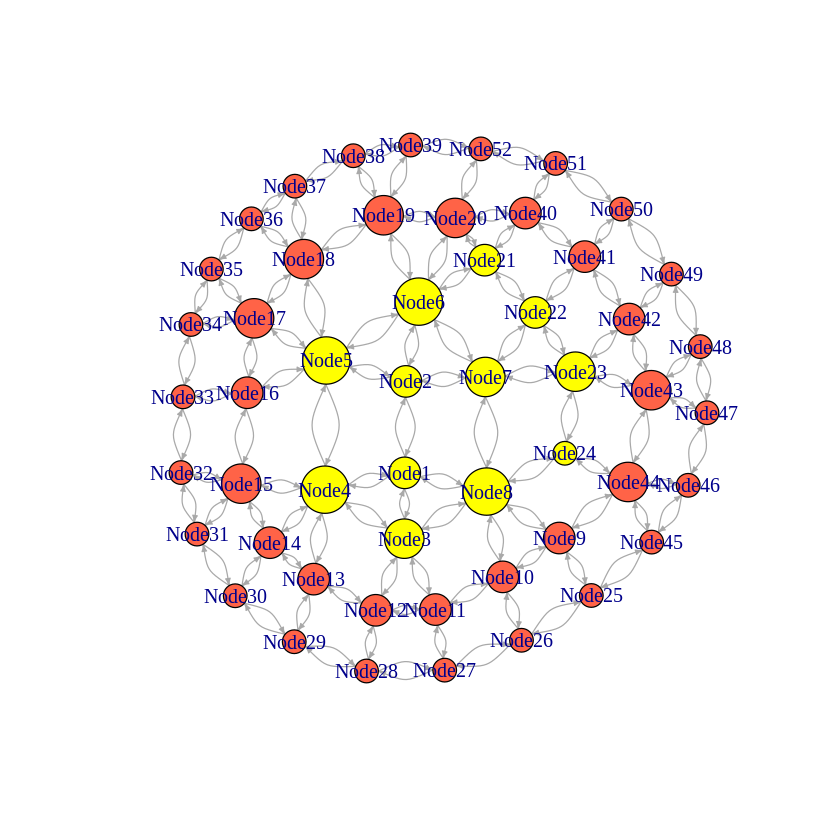

In [18]:
#plot graph
V(g)$color <- "tomato"
V(g)$color[national_nodes] <- "yellow"

deg <- degree(g, mode="all")
V(g)$size <- deg*1.5
l <- layout_nicely(g)
plot(g, edge.arrow.size=.3, vertex.label = V(g)$name, edge.curved=.5, layout=l)


Warning message:
“`as.undirected()` was deprecated in igraph 2.1.0.
ℹ Please use `as_undirected()` instead.”


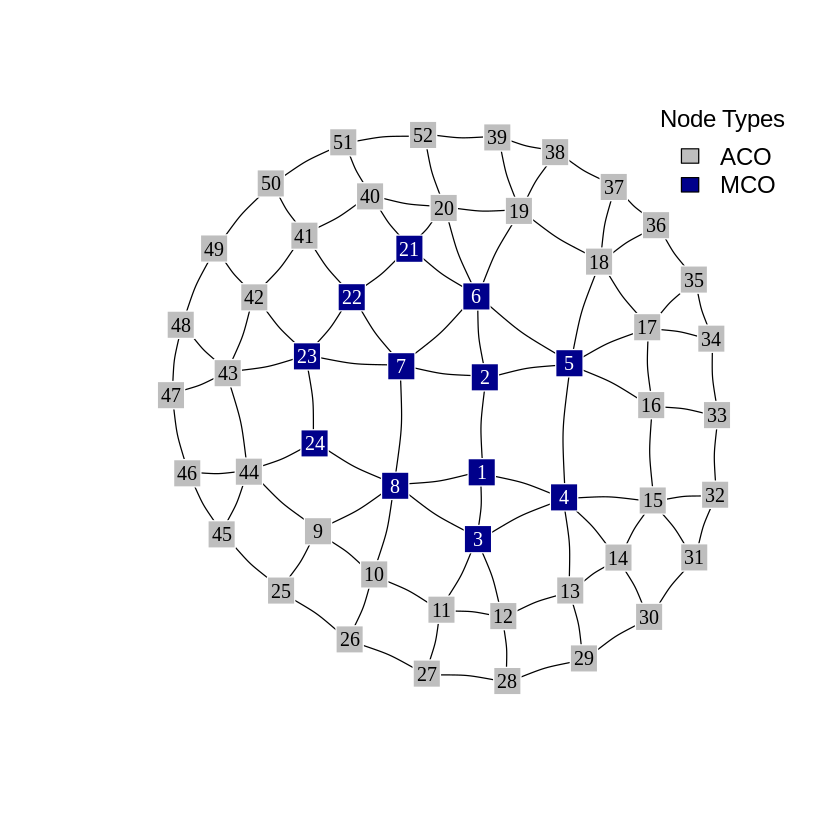

In [19]:
# Plot graph
g1 <- as.undirected(g)
V(g1)$name <- c(1:length(V(g1)))

# Calculate degree and scale node size
deg <- degree(g1, mode = "all")
V(g1)$size <- 10  # Adjust scaling factor for better visibility

V(g1)$color <- "gray"  # Default color for all nodes
V(g1)$color[national_nodes] <- "darkblue"  # Color for national nodes

# Set label color based on node type
V(g1)$label.color <- "black"  # Default label color
V(g1)$label.color[national_nodes] <- "white"  # Label color for national nodes


# Calculate degree and scale node size
deg <- degree(g1, mode = "all")
V(g1)$size <- 10  # Adjust scaling factor for better visibility

# Use an undirected layout
l <- layout_nicely(g1)

# Plot the graph with enhanced appearance
plot(g1,
     edge.arrow.size = 0,        # Remove edge arrows
     vertex.shape = "square",
     vertex.label = V(g1)$name,          # Remove node labels
     vertex.label.color = V(g1)$label.color,  # Set label color

     edge.curved = 0.1,          # Slight curve for edges
     layout = l,
     vertex.size = V(g1)$size,    # Set vertex size based on degree
     vertex.color = V(g1)$color,  # Set vertex color
     vertex.frame.color = "white",  # Remove border around vertices
     edge.color = "black"         # Set edge color to gray
)
# Add the legend
legend("topright",                    # Position of the legend
       legend = c("ACO", "MCO"),       # Labels
       fill = c("gray", "darkblue"),   # Colors corresponding to the labels
       title = "Node Types",           # Title of the legend
       bty = "n",                      # No box around the legend
       cex = 1.2)                      # Font size of legend text

#Igraph calculations

## Total traffic calculatons


## Calculations of the load, average number of packets, queueing and propagation delays:

Load for Local COs $0.3$;

Regional COs $0.5$;

Rational COs $0.4$

In [20]:
c(g_c10, data_av, data_99) := simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist = 1, distance = 0.5, Load_local, Load_regional, Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)

#Simmer simulation

Including queuing, transmission, propagation delay

Output table with links information

Simulation of all traffic flows, comparision of experimental with theretical

## Memory Usage and running time estimation


For Google Collab

In [21]:
mem_usage_calc <- function(){
  output <- system('grep "MemTotal" /proc/meminfo', intern = TRUE)

  # Extract the Total Physical Memory values (remove 'Mem Usage: ' and keep the numeric part)

  mem_lines <- sub("MemTotal:       ", "", output)
  memory_total <- sub(" kB", "", mem_lines)

  memory_total <- as.numeric(memory_total)


  output <- system('grep "MemAvailable" /proc/meminfo', intern = TRUE)
  mem_lines <- sub("MemAvailable:   ", "", output)
  memory_usage <- sub(" kB", "", mem_lines)
  memory_usage <- as.numeric(memory_usage)

  # Convert the total memory usage from KB to MB
  total_mem_usage_mb <- memory_total - memory_usage

  # Print the total memory usage in MB
  cat("Total memory usage:", total_mem_usage_mb/1024, "MB\n")
  return(total_mem_usage_mb)
}

In [24]:
detectCores()


[1] 8

In [65]:
gc(full=TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1414551,75.6,2211275,118.1,2211275,118.1
Vcells,2593429,19.8,8388608,64.0,8385838,64.0


In [30]:
start_mem <- mem_usage_calc()
start_time <- proc.time()
c(traffic_file$Delay_sim_s, traffic_file$Delay_th_s, traffic_file$D99_sim_s, traffic_file$VPbound_99th_s, g_c10) :=
  simulation_simmer(g_c10, traffic_file, PS_size, PS_weights, load = 0.3,
  CapacityGbps = CapacityGbps, ncores=4)
print(traffic_file)
# c(traffic_file$Delay_sim_s, traffic_file$Delay_th_s, traffic_file$D99_sim_s, traffic_file$VPbound_99th_s, g_c10) := simulation_simmer(g_c10, traffic_file, PS_size, PS_weights, load = 0.3, CapacityGbps = CapacityGbps)
traffic_file_v2 <- dplyr::filter(traffic_file, VPbound_99th_s != 0)
print(traffic_file_v2)
end_time <- proc.time()
end_mem <- mem_usage_calc()
gc(full=TRUE)

Total memory usage: 1599.906 MB
[1] "start simulation in simmer"
Load =  0.3 
socket cluster with 4 nodes on host ‘localhost’
[[1]]
[1] 7.436805e-06 3.436805e-06 4.000000e-06 7.663312e-06 1.688029e-05
[6] 2.370487e-05

[[2]]
[1] 7.436805e-06 3.436805e-06 4.000000e-06 7.663312e-06 1.688029e-05
[6] 2.370487e-05

[[3]]
[1] 3.374621e-06 1.874621e-06 1.500000e-06 3.184935e-06 8.917019e-06
[6] 1.587209e-05

[[4]]
[1] 3.374621e-06 1.874621e-06 1.500000e-06 3.184935e-06 8.917019e-06
[6] 1.587209e-05

[[5]]
[1] 3.374621e-06 1.874621e-06 1.500000e-06 3.184935e-06 8.917019e-06
[6] 1.587209e-05

[[6]]
[1] 3.374621e-06 1.874621e-06 1.500000e-06 3.184935e-06 8.917019e-06
[6] 1.587209e-05

[[7]]
[1] 6.936805e-06 3.436805e-06 3.500000e-06 6.951720e-06 1.434427e-05
[6] 2.320487e-05

[[8]]
[1] 3.374621e-06 1.874621e-06 1.500000e-06 3.184935e-06 8.917019e-06
[6] 1.587209e-05

[[9]]
[1]   0   0 NaN   0   0   0

[[10]]
[1]   0   0 NaN   0   0   0

[[11]]
[1]   0   0 NaN   0   0   0

[[12]]
[1]   0   0 NaN 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1408632,75.3,2491864,133.1,2491864,133.1
Vcells,2578608,19.7,8388608,64.0,8386473,64.0


In [26]:
traffic_file_v2

sourceID,destinationID,trafficGbps,service,traffic_ps,latencyPropTransQueuing_theor_s_mg1,latencyPercentile99_theor_s_mg1,Delay_sim_s,Delay_th_s,D99_sim_s,VPbound_99th_s
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [95]:
end_time <- proc.time()
end_mem <- mem_usage_calc()#end_time <- proc.time()
#end_mem <- mem_usage_calc()
execution_time <- end_time - start_time
memory_used <- end_mem - start_mem
# Print with a custom message
cat("Memory usage during code execution:\n")
cat("  Used memory: ", memory_used, "Mb \n")
cat(sprintf("Execution time on DES:\n Elapsed: %.3f seconds\n",
            execution_time["elapsed"]))

Total memory usage: 1422.445 MB
Memory usage during code execution:
  Used memory:  -787496 Mb 
Execution time on DES:
 Elapsed: 1545.738 seconds


In [ ]:
a = data.frame(sapply(ls(),function(x){object.size(get(x))}))
names(a)[1] <- "num"
print(sum(a[1]))
#rm(traffic_file_v2)
gc()
a = data.frame(sapply(ls(),function(x){object.size(get(x))}))
names(a)[1] <- "num"
print(sum(a[1]))
#install.packages("pryr")
#library(pryr)
print(a)


[1] 1261032


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1433131,76.6,5778985,308.7,7223731,385.8
Vcells,4571546,34.9,51551634,393.4,53432351,407.7


[1] 1267176
                                                   num
:=                                               56152
a                                                 6144
bounds_function_1w_path                          23888
bounds_function_node                             29000
calc_full_traffic_for_matrix                     41040
calc_queue_delay_burst                           20888
calc_traffic_links_for_matrix                    14200
calc_traffic_nodes_for_matrix                    29040
CapacityGbps                                        56
Cs2                                                 56
data_99                                            368
data_av                                            368
deg                                               1864
end_mem                                             56
end_time                                           848
file_name_v2                                       232
func_bounds_chebyshev                             515

#Results

In [ ]:
links_info_df

sourceID,destinationID,distanceKm,capacityGbps,prop_delay_s
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Node1,Node2,1.0,0.0000,5e-06
Node1,Node3,1.0,0.0000,5e-06
Node1,Node4,1.0,0.0000,5e-06
Node1,Node8,1.0,3824.0075,5e-06
Node2,Node1,1.0,0.0000,5e-06
Node2,Node5,1.0,3997.5144,5e-06
Node2,Node6,1.0,0.0000,5e-06
Node2,Node7,1.0,0.0000,5e-06
Node3,Node1,1.0,0.0000,5e-06


In [ ]:
traffic_file_v2

sourceID,destinationID,trafficGbps,service,traffic_ps,latencyPropTransQueuing_theor_s_mg1,latencyPercentile99_theor_s_mg1,Delay_sim_s,Delay_th_s,D99_sim_s,VPbound_99th_s
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Node1,Node9,3,CWB,367995.2,7.436805e-06,2.370487e-05,7.212010e-06,7.436805e-06,1.537633e-05,2.370487e-05
Node2,Node16,3,CWB,367995.2,7.436805e-06,2.370487e-05,7.212010e-06,7.436805e-06,1.537633e-05,2.370487e-05
Node3,Node11,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05
Node4,Node13,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05
Node5,Node16,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05
Node6,Node19,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05
Node7,Node9,3,CWB,367995.2,6.936805e-06,2.320487e-05,6.717610e-06,6.936805e-06,1.489532e-05,2.320487e-05
Node8,Node9,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05
Node20,Node19,3,CWB,367995.2,3.374621e-06,1.587209e-05,3.255116e-06,3.374621e-06,1.012569e-05,1.587209e-05


#Calculation of delays for different capacities

In [ ]:

c(g_c10_dg_l05, data_av_c10_dg_l05, data_99_c10_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist = 0, distance = 5, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c40_dg_l05, data_av_c40_dg_l05, data_99_c40_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 40, calc_dist = 0,  distance = 5, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c100_dg_l05, data_av_c100_dg_l05, data_99_c100_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 0,  distance = 5, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c400_dg_l05, data_av_c400_dg_l05, data_99_c400_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 400, calc_dist = 0,  distance = 5, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


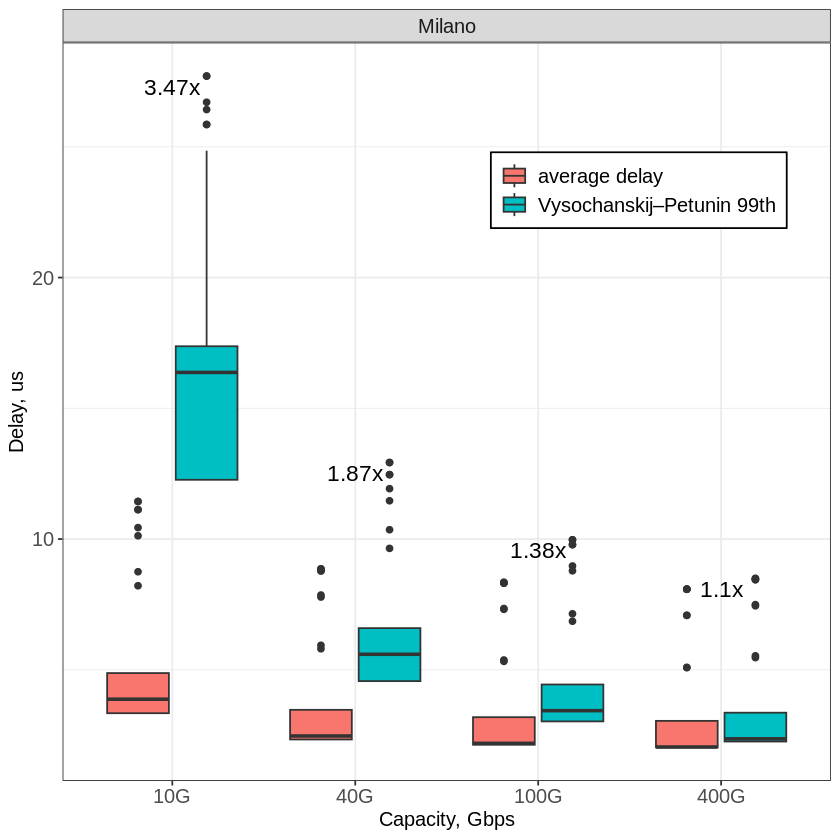

In [ ]:
#Boxplots

df_plot_capacity <- data.frame(capacity = c(rep("10G", length(data_99_c10_dg_l05)),
                                            rep("40G", length(data_99_c40_dg_l05)),
                                            rep("100G", length(data_99_c100_dg_l05)),
                                            rep("400G", length(data_99_c400_dg_l05)),
                                            rep("10G", length(data_av_c10_dg_l05)),
                                            rep("40G", length(data_av_c40_dg_l05)),
                                            rep("100G", length(data_av_c100_dg_l05)),
                                            rep("400G", length(data_av_c400_dg_l05))),
                               value = c(data_99_c10_dg_l05,
                                         data_99_c40_dg_l05,
                                         data_99_c100_dg_l05,
                                         data_99_c400_dg_l05,
                                         data_av_c10_dg_l05,
                                         data_av_c40_dg_l05,
                                         data_av_c100_dg_l05,
                                         data_av_c400_dg_l05),
                               type_of_calc = c(rep("Vysochanskij–Petunin 99th",length(data_99_c10_dg_l05)*4),
                                                rep("average delay",length(data_99_c10_dg_l05)*4)),
                               city = c(rep(topology_name,length(data_99_c10_dg_l05)*8)))

# Calculate the mean N values for each capacity group
N_means <- c(mean(data_99_c10_dg_l05)/mean(data_av_c10_dg_l05),
             mean(data_99_c40_dg_l05)/mean(data_av_c40_dg_l05),
             mean(data_99_c100_dg_l05)/mean(data_av_c100_dg_l05),
             mean(data_99_c400_dg_l05)/mean(data_av_c400_dg_l05))
N_means_y <- c(max(data_99_c10_dg_l05),
               max(data_99_c40_dg_l05),
               max(data_99_c100_dg_l05),
               max(data_99_c400_dg_l05))

text_size = 12
# Grouped boxplot
ggplot(df_plot_capacity, aes(x = fct_reorder(capacity, value, .desc = TRUE), y = value * 1000000, fill = type_of_calc)) +
  geom_boxplot() +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    legend.position = c(0.75, 0.8),
    axis.title.y = element_text(size = text_size),
    axis.title.x = element_text(size = text_size),
    legend.text = element_text(size = text_size),
    legend.background = element_rect(colour = "black"),
    axis.text = element_text(size = text_size),
    strip.text = element_text(size = text_size)
  ) +
  facet_grid(. ~ city ) +
  ylab("Delay, us") +
  xlab("Capacity, Gbps") +
  annotate("text", x = c(1,2,3,4), y = N_means_y*1e6 - 1,
           label = paste0(round(N_means, 2), "x"), vjust = -0.5, size = text_size/2.5)

#Calculation of delays for different distances

In [ ]:
#Calculation of delays for different distances
c(g_c100_d05g_l05, data_av_c100_d05g_l05, data_99_c100_d05g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 0.5, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c100_d2g_l05, data_av_c100_d2g_l05, data_99_c100_d2g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 2, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c100_d4g_l05, data_av_c100_d4g_l05, data_99_c100_d4g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 4, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)
c(g_c100_d10g_l05, data_av_c100_d10g_l05, data_99_c100_d10g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 10, Load_local = Load_local, Load_regional = Load_regional, Load_national = Load_national, prefix_base, national_nodes, regional_nodes , N, Cs2)

[1] "0.5x diam 2.3 km av link dist 0.28 km"

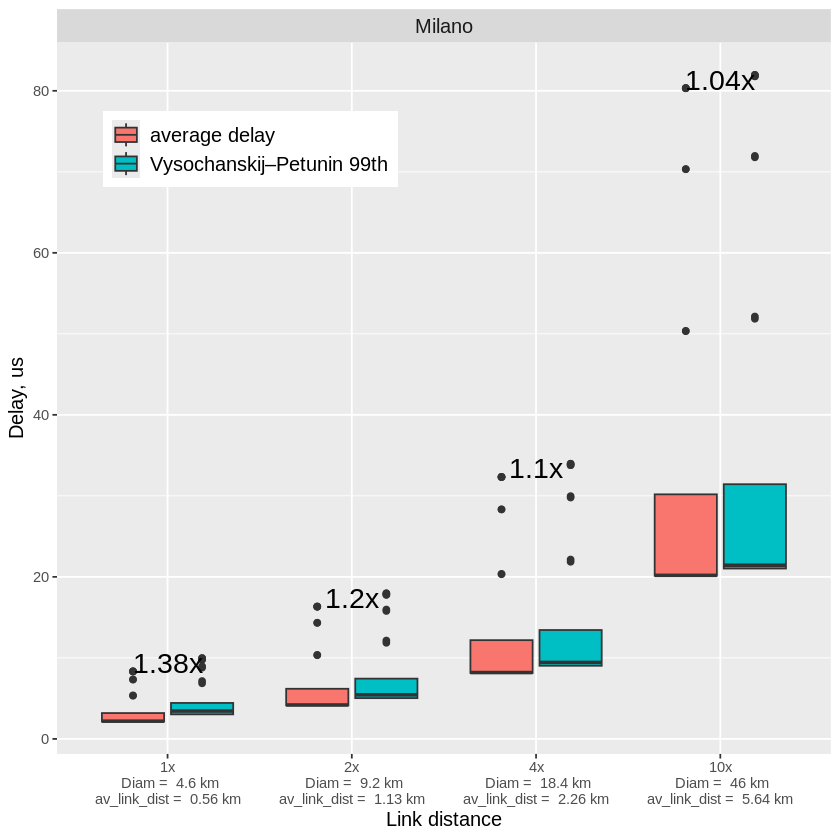

In [ ]:
diam_km <-  round(diameter(g_c100_d05g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d05g_l05)$Distance), digits = 2)
av_link_km <- round(mean(E(g_c100_d05g_l05)$Distance), digits = 2)
name_05 <- paste0("0.5x\n", "Diam = ", diam_km, "km\n av_link_dist", " = ", av_link_km, "km")
name_1 <- paste("1x\n", "Diam = ", round(diameter(g_c100_dg_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_dg_l05)$Distance), digits = 2), "km\nav_link_dist = ", round(mean(E(g_c100_dg_l05)$Distance), digits = 2), "km")
name_2 <- paste("2x\n", "Diam = ", round(diameter(g_c100_d2g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d2g_l05)$Distance), digits = 2), "km\nav_link_dist = ", round(mean(E(g_c100_d2g_l05)$Distance), digits = 2), "km")
name_4 <- paste("4x\n", "Diam = ", round(diameter(g_c100_d4g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d4g_l05)$Distance), digits = 2), "km\nav_link_dist = ", round(mean(E(g_c100_d4g_l05)$Distance), digits = 2), "km")
name_10 <- paste("10x\n", "Diam = ", round(diameter(g_c100_d10g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d10g_l05)$Distance), digits = 2), "km\nav_link_dist = ", round(mean(E(g_c100_d10g_l05)$Distance), digits = 2), "km")

####distanceVSdelay
distance = c(
             rep(name_1, length(data_99_c100_dg_l05)),
             rep(name_2, length(data_99_c100_d2g_l05)),
             rep(name_4, length(data_99_c100_d4g_l05)),
             rep(name_10, length(data_99_c100_d10g_l05)),
             rep(name_1, length(data_av_c100_dg_l05)),
             rep(name_2, length(data_av_c100_d2g_l05)),
             rep(name_4, length(data_av_c100_d4g_l05)),
             rep(name_10, length(data_av_c100_d10g_l05))
  )

type_of_calc = c(rep("Vysochanskij–Petunin 99th",length(distance)/2),
                 rep("average delay",length(distance)/2))

paste("0.5x", "diam", diam_km, "km av link dist", av_link_km, "km")
value = c(
  data_99_c100_dg_l05,
  data_99_c100_d2g_l05,
  data_99_c100_d4g_l05,
  data_99_c100_d10g_l05,
  data_av_c100_dg_l05,
  data_av_c100_d2g_l05,
  data_av_c100_d4g_l05,
  data_av_c100_d10g_l05
  )

df_plot_dist <- data.frame(distance, value, type_of_calc, city = c(rep(topology_name,length(type_of_calc))))

N_means_delay <- c(
  mean(data_99_c100_dg_l05) / mean(data_av_c100_dg_l05),
  mean(data_99_c100_d2g_l05) / mean(data_av_c100_d2g_l05),
  mean(data_99_c100_d4g_l05) / mean(data_av_c100_d4g_l05),
  mean(data_99_c100_d10g_l05) / mean(data_av_c100_d10g_l05)
)

N_means_delay_y <- c(
  max(data_99_c100_dg_l05) ,
  max(data_99_c100_d2g_l05),
  max(data_99_c100_d4g_l05),
  max(data_99_c100_d10g_l05)
)

df_plot_dist$distance <- factor(df_plot_dist$distance, levels = c(name_1, name_2, name_4, name_10))

text_size = 12
# grouped df_plot_dist
ggplot(df_plot_dist, aes(x=distance, y=value*1000000, fill=type_of_calc)) +
  geom_boxplot()+
  theme_gray() +
  theme(
     legend.title = element_blank(), legend.position = c(0.25, 0.85),
     axis.title.y = element_text(size = text_size),
     axis.title.x = element_text(size = text_size),
     legend.text = element_text(size = text_size),
     strip.text = element_text(size = text_size)
   ) +
  facet_grid(.~city)+
  ylab("Delay, us") +
  xlab("Link distance") +
  annotate("text", x = c(1,2,3,4), y = N_means_delay_y*1e6-3,
           label = paste0(round(N_means_delay, 2), "x"), vjust = -0.5, size = text_size/2)



#Creating the report file

In [ ]:
update_file <- function(links_info_df, traffic_file, file_name = "Milano_topology_result.xlsx", file_old_name)
{
    wb <- createWorkbook()
    addWorksheet(wb, sheetName = "Nodes")
    writeData(wb, sheet = 1, read_excel(file_old_name, sheet = 1))
    addWorksheet(wb, sheetName = "Links")
    writeData(wb, sheet = 2, links_info_df)
    addWorksheet(wb, sheetName = "Services")
    writeData(wb, sheet = 3, traffic_file)
    saveWorkbook(wb, file_name, overwrite = TRUE)
}




In [ ]:
update_file(links_info_df, traffic_file_v2, file_name = paste0(topology_name, "_topology_result.xlsx"), file_old_name = file_name_v2)
